# Using intern to download free neuroscience data from BossDB.org

In this notebook, we'll explore using the `intern` library to download neuroimagery datasets from [BossDB](https://bossdb.org). BossDB is a data archive that stores petabytes of 3D and 4D x-ray data, electron microscopy, MRI, light microscopy, and more.

## 1: Choosing a dataset

We'll choose a dataset to inspect. This is often easiest from the BossDB.org projects page (https://bossdb.org/projects), but you can also list available projects using `intern`. (For more details, see the companion notebook on listing datasets.)

In this notebook, we'll explore the seminal dataset from [_"Saturated reconstruction of a volume of cortex"_](https://pubmed.ncbi.nlm.nih.gov/26232230/) (Kasthuri et al., Cell 2015), available from https://bossdb.org/project/kasthuri2015.

To begin, we'll see how large the dataset is:

In [1]:
from intern import array

In [2]:
dataset = array("bossdb://Kasthuri/ac4/em")

In [3]:
dataset.shape

(100, 1024, 1024)

As you can see above, `intern.array` creates an object that thinks it's a numpy array, complete with `.shape` and `dtype` attributes:

In [4]:
dataset.dtype

'uint8'

## 2: Downloading a subvolume

Because some BossDB datasets are many terabytes or even petabytes in size, it doesn't make sense to try to download the entire dataset all in one go. Instead, you'll probably find that you want to focus on small chunks of the data when running algorithms or processing locally. 

`intern` makes it easy to download data: We can just treat the dataset like a giant numpy array.

**Note that array coordinates are stored in ZYX order, as a convention.** This will make some later steps easier, but it can be a common "gotcha" for new users!

In [5]:
my_cutout = dataset[20:22, 256:768, 256:768]

Once the cell above has completed, we have a 2×512×512 pixel cutout:

In [6]:
my_cutout.shape

(2, 512, 512)

Unlike the `dataset` variable, this cutout is actually downloaded and available on your computer!

Let's use matplotlib to render a slice of it:

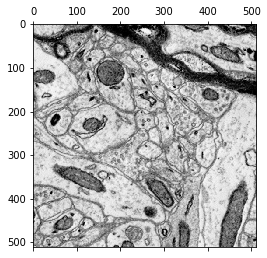

In [7]:
import matplotlib.pyplot as plt

plt.matshow(my_cutout[0], cmap="Greys_r")

## 3: Coregistered channels

What else can we do?

BossDB stores data in "channels," and some projects have more than just imagery: For example, this dataset also has a dense 3D neuron segmentation channel. Let's make the same cutout of this new dataset, and overlay the two:

In [8]:
neuron_segmentation = array("bossdb://Kasthuri/ac4/neuron")
my_segmentation_cutout = neuron_segmentation[20:22, 256:768, 256:768]

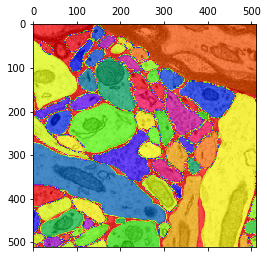

In [9]:
plt.matshow(my_cutout[0], cmap="Greys_r")
plt.imshow(my_segmentation_cutout[0], cmap="prism", alpha=0.7)

Let's add in membrane and synapse channels:

In [10]:
mem = array("bossdb://Kasthuri/ac4/membrane")[20, 256:768, 256:768]
syn = array("bossdb://Kasthuri/ac4/synapse")[20, 256:768, 256:768]

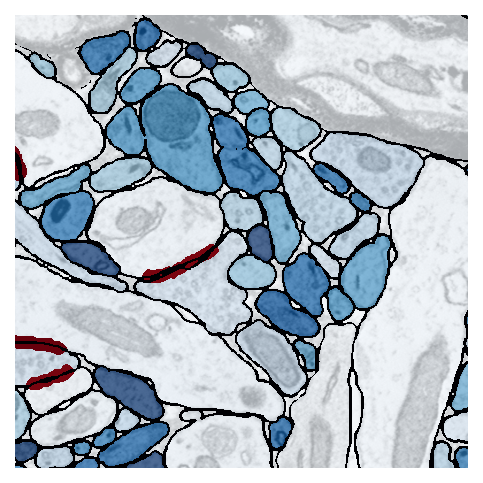

In [11]:
plt.figure(figsize=(4, 4), dpi=150)
plt.imshow(my_cutout[0], cmap="Greys_r")
plt.imshow(my_segmentation_cutout[0], cmap="Blues", alpha=0.7)

plt.imshow(syn, cmap="Reds", alpha=(syn > 0).astype("uint8"))
plt.imshow(mem, cmap="magma_r", alpha=(mem > 0).astype("uint8"))
plt.axis("off")
plt.show()

## 4: Downsampled data

Sometimes we want to see a large _span_ of tissue, but we don't care about pulling it down to our local compute resources at high resolution (e.g. for visualization or gross anatomical analyses). 

BossDB and intern support this use-case by providing server-side downsampled data. Rather than downloading large volumes of data and then throwing away the high resolution information, BossDB will instead serve a lower-resolution cutout, saving you time and bandwidth. With this technique, it is possible to download and visualize full datasets without waiting for terabytes of data to download and save.

To download a downsampled cutout, we'll simply pass a `resolution` argument to the array constructor.

Resolution 0 is the highest resolution data available; resolution 1 (or "res 1") holds a downsample of every other pixel; res 2 stores every 4 pixels, and so on. As a rule of thumb, if a cube of data is 1 terabyte, then res 1 is one eighth of a terabyte (125 GB), res 2 is a little under 16 GB, and so on. (BossDB also supports anisotropic downsampling, if an imaging modality is not imaged with equal resolution. More on that later!)

To illustrate, let's download a large cutout from _"Reconstruction of motor control circuits in adult Drosophila using automated transmission electron microscopy"_ (Phelps, Hildebrand, & Graham et al., Cell 2021) (https://bossdb.org/project/phelps_hildebrand_graham2021)

In [12]:
downsampled_dataset = array("bossdb://phelps_hildebrand_graham2021/FANC/em", resolution=6)

In [13]:
downsampled_cutout = downsampled_dataset[1000, :, 0:1500]

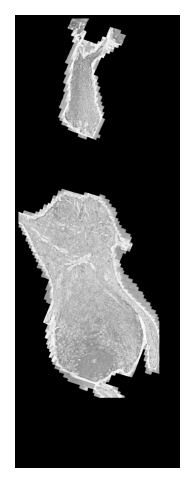

In [14]:
plt.figure(dpi=150)
plt.imshow(downsampled_cutout, cmap="Greys_r")
plt.axis("off")
plt.show()

Though this dataset spans many terabytes on disk, we are able to rapidly view gross morphology through this downsample service.

## 5: Wrap-up

In this notebook, we learned how to download data from BossDB, we coregistered multiple channels, and finally we looked at an advanced use-case where we let BossDB downsample data before sending it back to us. In companion notebooks, we will next investigate how to upload our own data, and share it privately with collaborators or with the world.